# Text Analysis
The data was manually web-scraped from deepmind.com/blog, the script is 'scraper_deepmind.py'

Additional resources for clustering / generating visuals:

* https://medium.com/@lucasdesa/text-clustering-with-k-means-a039d84a941b
*  https://www.youtube.com/watch?v=ORpDAUQUnkU
* https://towardsdatascience.com/text-clustering-using-k-means-ec19768aae48
* https://medium.com/@MSalnikov/text-clustering-with-k-means-and-tf-idf-f099bcf95183
* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Resources for NLTK:

* https://www.nltk.org/

Anas Puthawala

# Imports

In [321]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
# from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import scale

from scipy.spatial.distance import cdist

from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer

# EDA

### Loading / Preprocessing data

In [322]:
df = pd.read_excel('D:\Anas\Downloads\Deepmind_scrape.xlsx')

In [323]:
df.head()

,Unnamed: 0,Title,Summary,Date,Type of Article
0,0,Language modelling at scale,"We are releasing three papers on language models, Gopher, ethical considerations, and retrieval.",08 Dec 2021,Research
1,1,Exploring the beauty of pure mathematics in novel ways,Discovering new patterns in the fields of topology and representation theory with machine learning,01 Dec 2021,Research
2,2,Real-World Challenges for AGI,"Koray Kavukcuoglu, VP of Research, discusses why addressing real-world challenges now helps advance the development of...",02 Nov 2021,NaN
3,3,Opening up a physics simulator for robotics,"As part of DeepMind's mission of advancing science, we have acquired the MuJoCo physics simulator and are making it...",18 Oct 2021,News
4,4,Stacking our way to more general robots,Introducing RGB-Stacking as a new benchmark for vision-based robotic manipulation.,11 Oct 2021,Research


In [324]:
print(f'NaNs in dataframe: {df.isna().sum().sum()}\n\n{df.dtypes}')

NaNs in dataframe: 12

Unnamed: 0         int64 
Title              object
Summary            object
Date               object
Type of Article    object
dtype: object


In [325]:
def preprocess(df):
    #Make a copy
    df2 = df.copy
    
    #Drop unnamed:0 column
    df2 = df.drop('Unnamed: 0', axis = 1)
    
    #Replace NaN's
    df2['Type of Article'] = df2['Type of Article'].replace(np.NaN, 'Unspecified')
    df2.Summary = df2.Summary.replace(np.NaN, 'Unspecified')
    
    #Convert date column to datetime
    df2.Date = pd.to_datetime(df2.Date)
    
    return df2

In [326]:
df = preprocess(df)

In [327]:
print(f'NaNs in dataframe: {df.isna().sum().sum()}\n\n{df.dtypes}')

NaNs in dataframe: 0

Title              object        
Summary            object        
Date               datetime64[ns]
Type of Article    object        
dtype: object


In [328]:
df.head()

,Title,Summary,Date,Type of Article
0,Language modelling at scale,"We are releasing three papers on language models, Gopher, ethical considerations, and retrieval.",2021-12-08,Research
1,Exploring the beauty of pure mathematics in novel ways,Discovering new patterns in the fields of topology and representation theory with machine learning,2021-12-01,Research
2,Real-World Challenges for AGI,"Koray Kavukcuoglu, VP of Research, discusses why addressing real-world challenges now helps advance the development of...",2021-11-02,Unspecified
3,Opening up a physics simulator for robotics,"As part of DeepMind's mission of advancing science, we have acquired the MuJoCo physics simulator and are making it...",2021-10-18,News
4,Stacking our way to more general robots,Introducing RGB-Stacking as a new benchmark for vision-based robotic manipulation.,2021-10-11,Research


### Extracting the dates (i.e. new column for year, month, and day)

In [329]:
def extract_dates(df):
    df2 = df.copy()
    
    df2['Day'] = df.Date.dt.day
    df2['Month'] = df.Date.dt.month
    df2['Year'] = df.Date.dt.year
    
    # Create a wrapper to replace months from digits (i.e. 1,2,3,...12) to text (i.e. January, February, March,... December)
    mapper = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
    df2.Month = df2.Month.replace(mapper)
    
    return df2

In [330]:
df = extract_dates(df)

In [331]:
df.head()

,Title,Summary,Date,Type of Article,Day,Month,Year
0,Language modelling at scale,"We are releasing three papers on language models, Gopher, ethical considerations, and retrieval.",2021-12-08,Research,8,December,2021
1,Exploring the beauty of pure mathematics in novel ways,Discovering new patterns in the fields of topology and representation theory with machine learning,2021-12-01,Research,1,December,2021
2,Real-World Challenges for AGI,"Koray Kavukcuoglu, VP of Research, discusses why addressing real-world challenges now helps advance the development of...",2021-11-02,Unspecified,2,November,2021
3,Opening up a physics simulator for robotics,"As part of DeepMind's mission of advancing science, we have acquired the MuJoCo physics simulator and are making it...",2021-10-18,News,18,October,2021
4,Stacking our way to more general robots,Introducing RGB-Stacking as a new benchmark for vision-based robotic manipulation.,2021-10-11,Research,11,October,2021


### Insights by visualizations

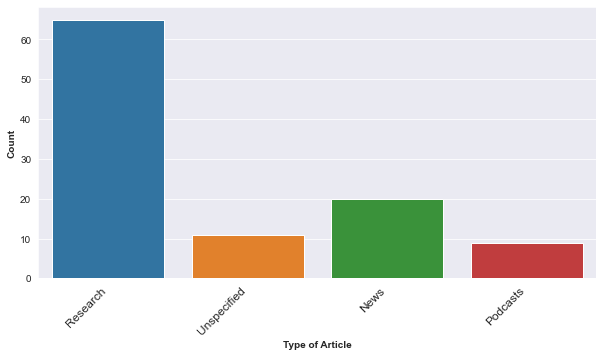

In [332]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    x='Type of Article',
    data=df,
);

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)

plt.xlabel('Type of Article',
           fontweight='bold',
           fontsize='medium'
          );

plt.ylabel('Count',
           fontweight='bold',
           fontsize='medium',
          );
# chart.invert_xaxis();

* #### A majority of the articles published by DeepMind were set to be 'Research' articles

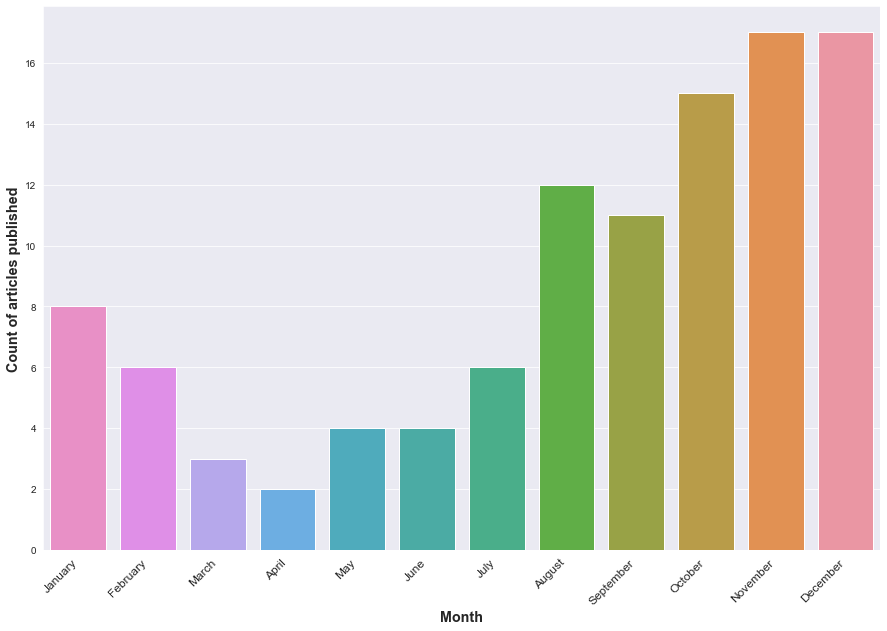

In [333]:
plt.figure(figsize=(15,10))
chart = sns.countplot(
    x='Month',
#     hue='Year',
    data=df,
);

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)

plt.xlabel('Month',
           fontweight='bold',
           fontsize='x-large'
          );

plt.ylabel('Count of articles published',
           fontweight='bold',
           fontsize='x-large',
          );

chart.invert_xaxis();

* #### A majority of articles were being published in the winter / fall months (very few in the summer months and months leading up to the summer)

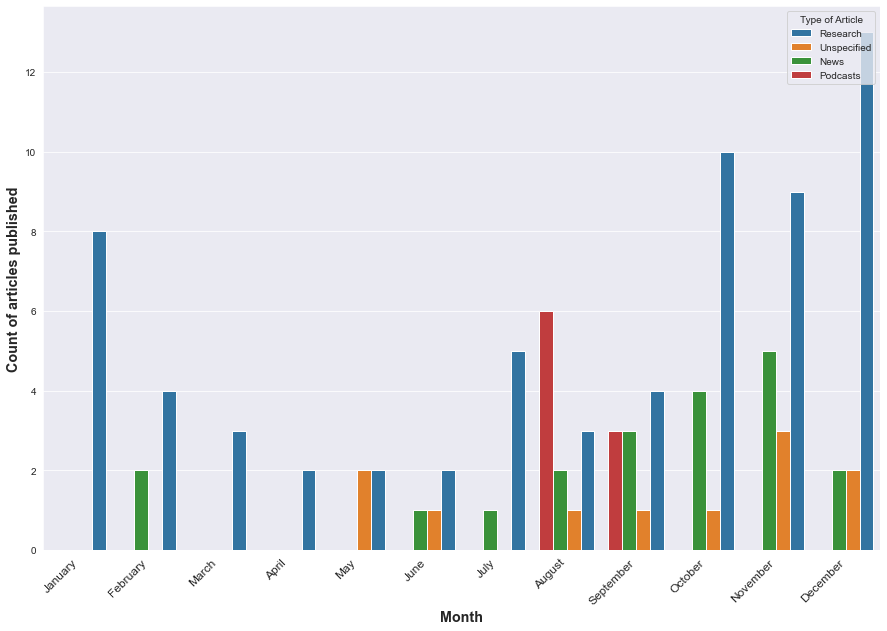

In [334]:
plt.figure(figsize=(15,10))
chart = sns.countplot(
    x='Month',
    hue='Type of Article',
    data=df,
);

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
);

plt.xlabel('Month',
           fontweight='bold',
           fontsize='x-large'
          );

plt.ylabel('Count of articles published',
           fontweight='bold',
           fontsize='x-large',
          );

chart.invert_xaxis();

* #### A majority of the research articles were published in the fall / winter months.
* #### Podcasts were published in solely August and September

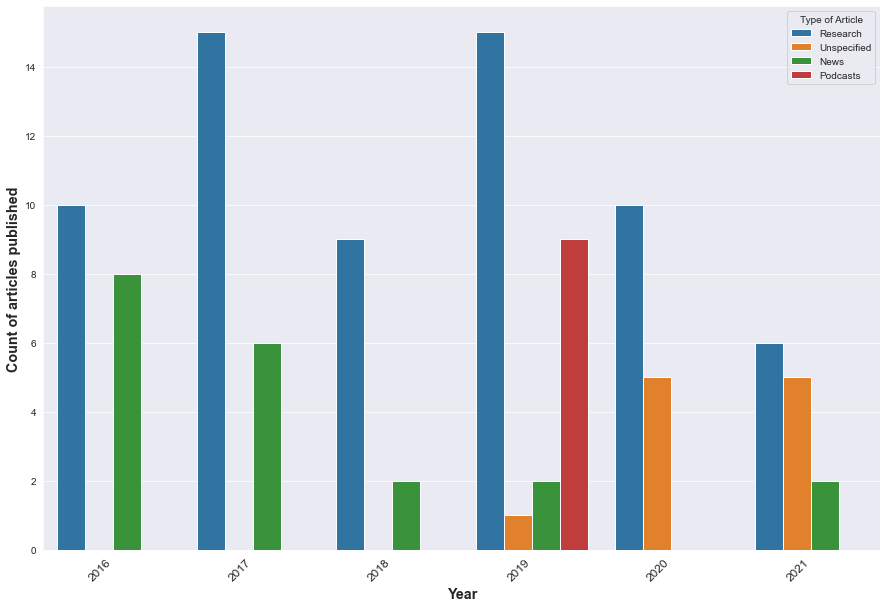

In [335]:
plt.figure(figsize=(15,10))
chart = sns.countplot(
    x='Year',
    hue='Type of Article',
    data=df,
);

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)

plt.xlabel('Year',
           fontweight='bold',
           fontsize='x-large'
          );

plt.ylabel('Count of articles published',
           fontweight='bold',
           fontsize='x-large',
          );
# chart.invert_xaxis();

* #### 2019 was the only year to publish podcasts

# Additional Data Cleaning / Preprocessing

In [336]:
pd.set_option("display.max_colwidth", -1)

<ipython-input-336-a09e5efec013>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


In [337]:
df

,Title,Summary,Date,Type of Article,Day,Month,Year
0,Language modelling at scale,"We are releasing three papers on language models, Gopher, ethical considerations, and retrieval.",2021-12-08,Research,8,December,2021
1,Exploring the beauty of pure mathematics in novel ways,Discovering new patterns in the fields of topology and representation theory with machine learning,2021-12-01,Research,1,December,2021
2,Real-World Challenges for AGI,"Koray Kavukcuoglu, VP of Research, discusses why addressing real-world challenges now helps advance the development of...",2021-11-02,Unspecified,2,November,2021
3,Opening up a physics simulator for robotics,"As part of DeepMind's mission of advancing science, we have acquired the MuJoCo physics simulator and are making it...",2021-10-18,News,18,October,2021
4,Stacking our way to more general robots,Introducing RGB-Stacking as a new benchmark for vision-based robotic manipulation.,2021-10-11,Research,11,October,2021
...,...,...,...,...,...,...,...
100,Decoupled Neural Interfaces Using Synthetic Gradients,"Neural networks are the workhorse of many of the algorithms developed at DeepMind. For example, AlphaGo uses...",2016-08-29,Research,29,August,2016
101,DeepMind AI Reduces Google Data Centre Cooling Bill by 40%,"From smartphone assistants to image recognition and translation, machine learning already helps us in our everyday...",2016-07-20,Research,20,July,2016
102,Announcing DeepMind Health research partnership with Moorfields Eye Hospital,We founded DeepMind to make the world a better place by developing technologies that help address some of society's...,2016-07-05,News,5,July,2016
103,Deep Reinforcement Learning,"Humans excel at solving a wide variety of challenging problems, from low-level motor control through to high-level...",2016-06-17,Research,17,June,2016


In [338]:
def clean_text(df):
    df2 = df.copy()
    
    #Removing the '...' and the period at the end of some of the summaries
    
    fun = df2.Summary #Arbitrary assignment to make code easier to read
    
    for idx, string in enumerate(fun):
        if fun[idx][-3:] == '...':
            fun[idx] = fun[idx].rstrip('...')
        elif fun[idx][-1:] == '.':
            fun[idx] = fun[idx].rstrip('.')

    return df2

In [339]:
df = clean_text(df)

<ipython-input-338-2fddbf1e4a35>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fun[idx] = fun[idx].rstrip('.')
<ipython-input-338-2fddbf1e4a35>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fun[idx] = fun[idx].rstrip('...')


#### For this clustering approach, we'll concatenate the Title and the Summary together to be one corpus, then process those corpus

In [340]:
df['Corpus'] = df['Title'] + ' ' + df['Summary']

In [341]:
df

,Title,Summary,Date,Type of Article,Day,Month,Year,Corpus
0,Language modelling at scale,"We are releasing three papers on language models, Gopher, ethical considerations, and retrieval",2021-12-08,Research,8,December,2021,"Language modelling at scale We are releasing three papers on language models, Gopher, ethical considerations, and retrieval"
1,Exploring the beauty of pure mathematics in novel ways,Discovering new patterns in the fields of topology and representation theory with machine learning,2021-12-01,Research,1,December,2021,Exploring the beauty of pure mathematics in novel ways Discovering new patterns in the fields of topology and representation theory with machine learning
2,Real-World Challenges for AGI,"Koray Kavukcuoglu, VP of Research, discusses why addressing real-world challenges now helps advance the development of",2021-11-02,Unspecified,2,November,2021,"Real-World Challenges for AGI Koray Kavukcuoglu, VP of Research, discusses why addressing real-world challenges now helps advance the development of"
3,Opening up a physics simulator for robotics,"As part of DeepMind's mission of advancing science, we have acquired the MuJoCo physics simulator and are making it",2021-10-18,News,18,October,2021,"Opening up a physics simulator for robotics As part of DeepMind's mission of advancing science, we have acquired the MuJoCo physics simulator and are making it"
4,Stacking our way to more general robots,Introducing RGB-Stacking as a new benchmark for vision-based robotic manipulation,2021-10-11,Research,11,October,2021,Stacking our way to more general robots Introducing RGB-Stacking as a new benchmark for vision-based robotic manipulation
...,...,...,...,...,...,...,...,...
100,Decoupled Neural Interfaces Using Synthetic Gradients,"Neural networks are the workhorse of many of the algorithms developed at DeepMind. For example, AlphaGo uses",2016-08-29,Research,29,August,2016,"Decoupled Neural Interfaces Using Synthetic Gradients Neural networks are the workhorse of many of the algorithms developed at DeepMind. For example, AlphaGo uses"
101,DeepMind AI Reduces Google Data Centre Cooling Bill by 40%,"From smartphone assistants to image recognition and translation, machine learning already helps us in our everyday",2016-07-20,Research,20,July,2016,"DeepMind AI Reduces Google Data Centre Cooling Bill by 40% From smartphone assistants to image recognition and translation, machine learning already helps us in our everyday"
102,Announcing DeepMind Health research partnership with Moorfields Eye Hospital,We founded DeepMind to make the world a better place by developing technologies that help address some of society's,2016-07-05,News,5,July,2016,Announcing DeepMind Health research partnership with Moorfields Eye Hospital We founded DeepMind to make the world a better place by developing technologies that help address some of society's
103,Deep Reinforcement Learning,"Humans excel at solving a wide variety of challenging problems, from low-level motor control through to high-level",2016-06-17,Research,17,June,2016,"Deep Reinforcement Learning Humans excel at solving a wide variety of challenging problems, from low-level motor control through to high-level"


In [342]:
# corps = df.Corpus.values.astype("U") #Convert the corpus column into a numpy array containing all individual rows from Corpus
corps = df.Corpus.values

# Clustering Analysis

In [343]:
# import nltk ---------- Uncomment & run if you don't have NLTK wordnet
# nltk.download('wordnet')

In [344]:
# Init the Wordnet Lemmatizer & RegexpTokenizer
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

In [345]:
def tokenize(text):
    return [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text.lower())]

In [346]:
vec = TfidfVectorizer(stop_words='english', tokenizer=tokenize)
features = vec.fit_transform(corps)

C:\Users\Anas\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [347]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer()
features = scaler.fit_transform(features)
features

<105x783 sparse matrix of type '<class 'numpy.float64'>'
	with 1476 stored elements in Compressed Sparse Row format>

In [348]:
word_features = vec.get_feature_names()
print(f'The number word_features is: {len(word_features)}\n\n{word_features}')

The number word_features is: 783

['ability', 'able', 'academia', 'academic', 'accelerate', 'access', 'accurate', 'achieve', 'achieved', 'achieving', 'acquired', 'active', 'actor', 'adaptively', 'address', 'addressing', 'advance', 'advanced', 'advancing', 'advantageous', 'agent', 'agi', 'ago', 'agreed', 'ai', 'aim', 'algorithm', 'algorithmic', 'allowing', 'alongside', 'alphafold', 'alphago', 'alphastar', 'alphazero', 'anaheim', 'analysis', 'analytics', 'announce', 'announced', 'announcing', 'annual', 'answer', 'app', 'applying', 'approach', 'apps', 'architecture', 'arrives', 'art', 'artificial', 'asked', 'assistant', 'asymmetric', 'atari', 'audio', 'augmented', 'august', 'auxiliary', 'avoidable', 'background', 'ball', 'barrier', 'based', 'bayesian', 'beauty', 'behave', 'behaviour', 'believe', 'benchmark', 'benefit', 'best', 'better', 'biological', 'biology', 'black', 'blizzard', 'blizzcon', 'block', 'blog', 'blogposts', 'boost', 'boundary', 'brain', 'breaking', 'breast', 'brief', 'brin

#### Elbow method to find optimal 'k'
The elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. - Wikipedia

i.e., plot the # of clusters and the variation and see if there is any visible 'elbow' in the plot

In [349]:
def elbow_method(feats):
    wcss = [] 
    K = range(1,15)
    for k in K: 
        kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
        kmeans.fit(feats) 
        wcss.append(kmeans.inertia_)
    plt.plot(K, wcss)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS') 
    plt.show()

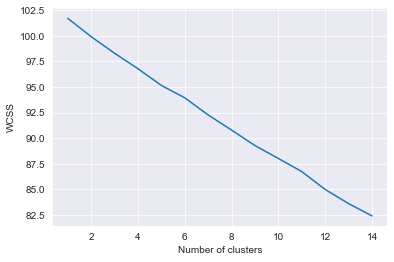

In [350]:
elbow_method(features)

Since there was no explicit elbow found, we can find the optimal 'k' by trial and error as well.

In [351]:
def cluster(features, n_clusters):
    
    kmeans = KMeans(n_clusters = n_clusters, random_state=1)
    kmeans.fit(features)
    
    common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
    
    for num, centroid in enumerate(common_words):
        print("Cluster " + str(num + 1) + ':') 
        print(', '.join(word_features[word] for word in centroid))
        print('----------------------------------------------------------------------------------')

### k = 2

In [352]:
cluster(features, 2)

Cluster 1:
ai, deepmind, learning, research, s, world, machine, paper, health, technology, partnership, model, solve, alphafold, using, help, new, reinforcement, episode, year, stream, learn, nh, ha, developing
----------------------------------------------------------------------------------
Cluster 2:
neural, game, network, agent, new, atari, training, human, mastering, strategy, like, play, benchmark, graph, memory, general, video, test, stacking, alphago, life, algorithm, map, work, alphazero
----------------------------------------------------------------------------------


### k = 3

In [353]:
cluster(features, 3)

Cluster 1:
neural, learning, paper, network, model, new, reinforcement, agent, nip, wavenet, deepmind, deep, machine, memory, google, ha, series, world, presenting, architecture, task, research, advance, physic, open
----------------------------------------------------------------------------------
Cluster 2:
deepmind, partnership, technology, year, nh, health, hospital, ve, announce, cancer, eye, alphafold, research, better, founded, s, patient, london, excited, free, proud, groundbreaking, world, working, moorfields
----------------------------------------------------------------------------------
Cluster 3:
ai, game, research, episode, deepmind, human, solve, learning, s, learn, u, using, researcher, like, team, used, starcraft, ii, agent, specification, push, boundary, intelligence, blizzard, hannah
----------------------------------------------------------------------------------


###  k = 4

In [354]:
cluster(features, 4)

Cluster 1:
ai, research, learning, episode, game, world, solve, machine, researcher, learn, advance, real, new, general, play, deepmind, deepmind's, u, mission, help, open, environment, task, theory, agent
----------------------------------------------------------------------------------
Cluster 2:
deepmind, health, technology, stream, nh, paper, s, excited, announce, year, ai, partnership, patient, research, ve, presenting, hospital, make, better, founded, nip, london, free, doctor, team
----------------------------------------------------------------------------------
Cluster 3:
learning, reinforcement, agent, deep, human, wide, wavenet, level, variety, model, speech, problem, architecture, new, data, ha, cooperation, building, perceiver, solution, synthesis, analysis, game, behaviour, alphastar
----------------------------------------------------------------------------------
Cluster 4:
neural, network, memory, computer, new, graph, alphago, model, differentiable, glass, nature, aug

###  k = 5

In [355]:
cluster(features, 5)

Cluster 1:
ai, research, episode, learning, solve, game, researcher, learn, general, world, deepmind's, mission, new, open, machine, environment, real, task, deepmind, boundary, push, play, hannah, robot, developing
----------------------------------------------------------------------------------
Cluster 2:
deepmind, health, technology, stream, nh, paper, excited, announce, year, s, partnership, patient, ve, presenting, hospital, make, better, founded, nip, london, free, doctor, team, series, mobile
----------------------------------------------------------------------------------
Cluster 3:
learning, reinforcement, agent, deep, human, wide, wavenet, level, variety, model, speech, problem, architecture, new, data, ha, cooperation, building, perceiver, solution, synthesis, analysis, game, behaviour, alphastar
----------------------------------------------------------------------------------
Cluster 4:
neural, network, memory, computer, new, graph, alphago, model, differentiable, glass,

###  k = 6

In [356]:
cluster(features, 6)

Cluster 1:
using, patient, alphafold, research, artificial, jax, model, nowcasting, ai, language, discovery, simulator, doctor, physic, science, scientific, life, vision, predict, intelligence, disease, paper, selection, evolutionary, driving
----------------------------------------------------------------------------------
Cluster 2:
machine, deepmind, learning, paper, help, research, ai, s, u, series, team, presenting, google, nip, community, world, challenge, health, icml, data, ha, strengthening, brief, description, second
----------------------------------------------------------------------------------
Cluster 3:
reinforcement, learning, agent, open, learn, ai, task, mission, sourcing, solve, environment, push, boundary, blizzard, developing, building, deep, new, level, deepmind, starcraft, ii, multi, general, architecture
----------------------------------------------------------------------------------
Cluster 4:
game, ai, episode, researcher, human, specification, like, agent,

###  k = 7

In [357]:
cluster(features, 7)

Cluster 1:
nh, stream, healthcare, announce, year, partnership, wavenet, excited, model, working, hospital, mobile, speech, foundation, nowcasting, disease, college, eye, research, trust, app, radiotherapy, simulator, art, state
----------------------------------------------------------------------------------
Cluster 2:
reinforcement, learning, agent, open, ai, learn, task, mission, new, sourcing, solve, environment, boundary, push, general, blizzard, developing, building, deep, level, useful, deepmind, ii, starcraft, research
----------------------------------------------------------------------------------
Cluster 3:
game, ai, episode, human, researcher, like, agent, important, specification, intelligence, ability, video, test, teach, different, hannah, life, robot, start, used, alphazero, hassabis, demis, analytics, sport
----------------------------------------------------------------------------------
Cluster 4:
deepmind, health, machine, s, research, learning, world, help, techn

### k = 8

In [358]:
cluster(features, 8)

Cluster 1:
learning, ai, episode, human, general, hannah, robot, reinforcement, ha, world, u, used, learn, solve, architecture, data, task, purpose, stacking, deep, train, teach, agent, potential, meet
----------------------------------------------------------------------------------
Cluster 2:
health, deepmind, stream, nh, announce, technology, partnership, excited, year, hospital, make, better, founded, patient, london, free, team, ve, mobile, like, foundation, college, s, help, healthcare
----------------------------------------------------------------------------------
Cluster 3:
graph, cooperation, glass, neural, look, network, understanding, advanced, agent, hosted, podcast, mathematician, broadcaster, welcome, aim, listener, fry, inside, notion, employ, sequential, emergence, learning, hannah, molecule
----------------------------------------------------------------------------------
Cluster 4:
game, theory, real, agent, alphastar, learning, video, test, decade, alphazero, world

### k = 9

In [359]:
cluster(features, 9)

Cluster 1:
research, ai, deepmind, jax, announced, eye, strengthening, translation, accelerate, opening, simulator, blizzard, today, physic, month, ago, predicting, robust, cancer, hand, moorfields, machine, unspecified, self, car
----------------------------------------------------------------------------------
Cluster 2:
nh, stream, year, partnership, london, free, announce, foundation, college, healthcare, trust, royal, groundbreaking, technology, radiotherapy, excited, energy, patient, working, mobile, yeovil, district, imperial, agreed, bringing
----------------------------------------------------------------------------------
Cluster 3:
learning, reinforcement, learn, solve, human, ai, episode, push, boundary, task, open, mission, developing, used, machine, behaviour, agent, objective, sourcing, specification, program, unsupervised, lab, building, ha
----------------------------------------------------------------------------------
Cluster 4:
game, agent, real, new, ai, alphastar

### Calculating the silhouette scores to help delineate optimal 'k'

In [360]:
def make_df_silhouette_scores(features, n_clusters_range):
    #Lists to append data to
    silhouette_scores = []
    n_cluster=[]
    
    #Looping in the range of 'k' to try out
    for n_clusters in n_clusters_range:
        n_cluster.append(n_clusters)
        
        #Run kmeans and extract the labels
        cluster_labels = KMeans(n_clusters = n_clusters).fit_predict(features)
       
        #Calculate the silhouette scores from the extracted labels after running kmeans and append
        silhouette_avg = silhouette_score(features, cluster_labels, random_state=1)
        silhouette_scores.append(silhouette_avg)
        
    # Output a dataframe which contains the silhouette scores for each K (cluster)   
    return pd.DataFrame(list(zip(silhouette_scores, n_cluster)), columns=['Silhouette Score','K (Clusters)'])

In [361]:
df_silhouette = make_df_silhouette_scores(features, range(2,10))

In [362]:
df_silhouette

,Silhouette Score,K (Clusters)
0,0.007927,2
1,0.007925,3
2,0.008372,4
3,0.012804,5
4,0.011352,6
5,0.013767,7
6,0.015365,8
7,0.016451,9


In [363]:
tf_idf = pd.DataFrame(data = features.toarray(), columns=word_features)

final_df = tf_idf

final_df.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
language,0.584034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
consideration,0.292017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gopher,0.292017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
modelling,0.292017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
releasing,0.292017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Visuals

## Barplots

In [364]:
k = 7
# kmeans_results = run_KMeans(k, final_df
kmeans =  KMeans(n_clusters = k, init = 'k-means++' , n_init = 10 , tol = 0.0001, 
                 n_jobs = -1, random_state = 1, algorithm = 'full')

In [365]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats, vectorizer):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    sns.set_style('darkgrid')
    palette = sns.color_palette("flare", as_cmap=True)
    for i in range(0, len(dfs)):
        plt.figure(figsize=(15, 7));
        plt.title((f'Most Common Words in Cluster {i}'), fontsize=13, fontweight='bold');
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats], palette = 'flare');
        plt.xlabel('Score', fontweight='bold', fontsize=13)
        plt.ylabel(f'Features in Cluster {i}', fontweight='bold', fontsize=13)
        
        plt.show();

C:\Users\Anas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\Anas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


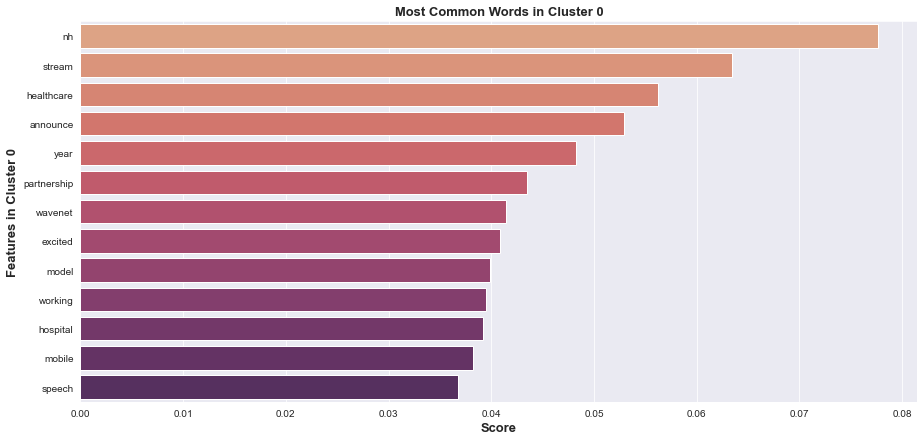

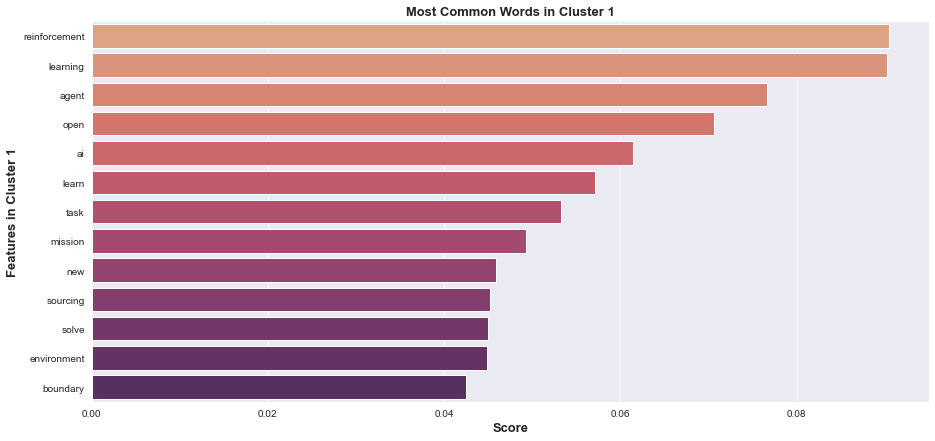

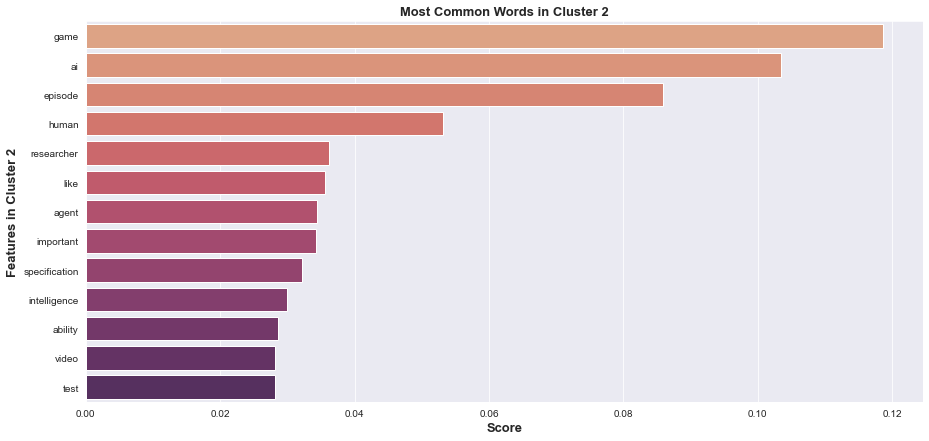

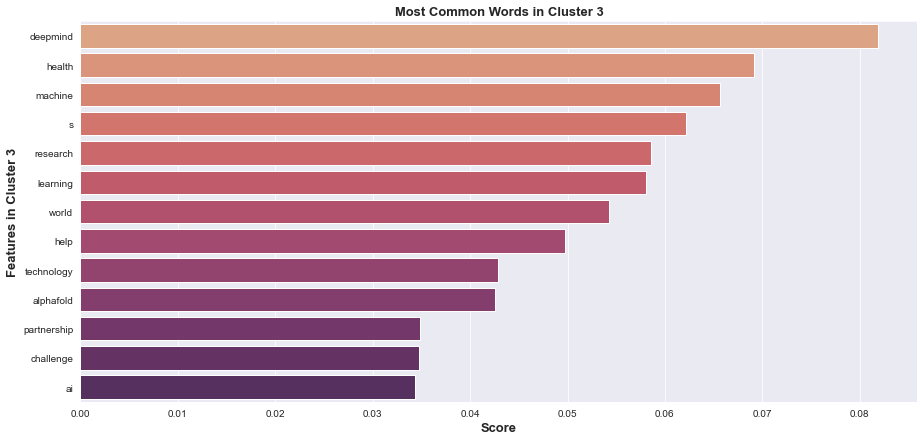

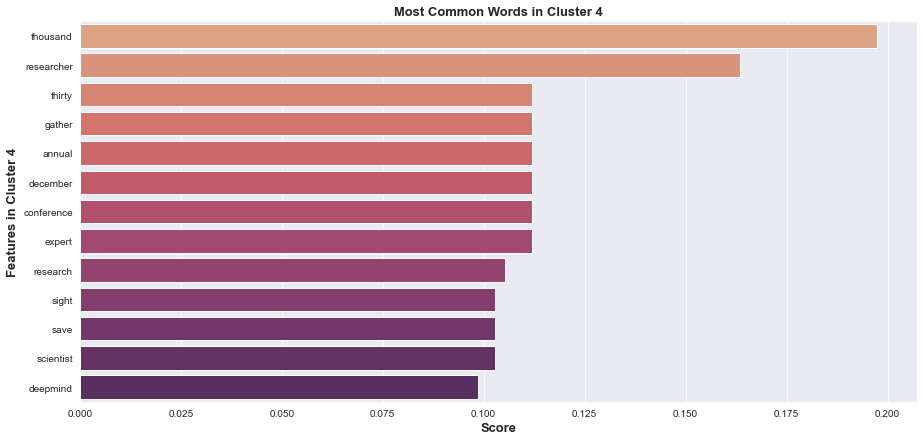

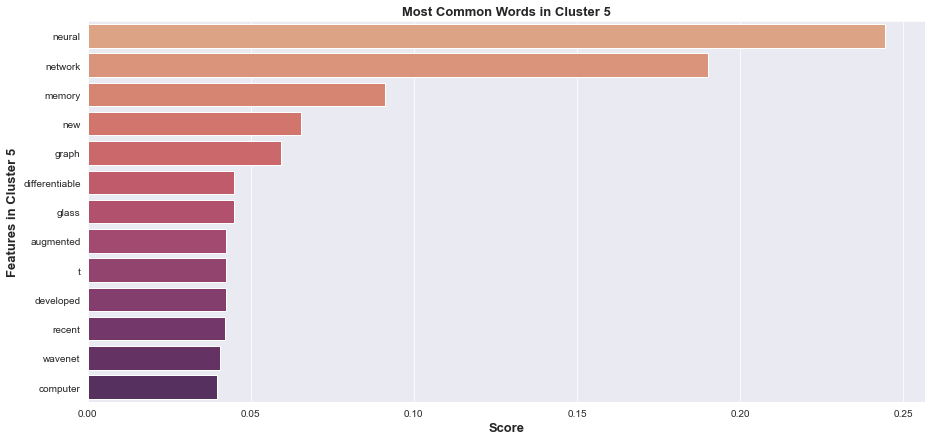

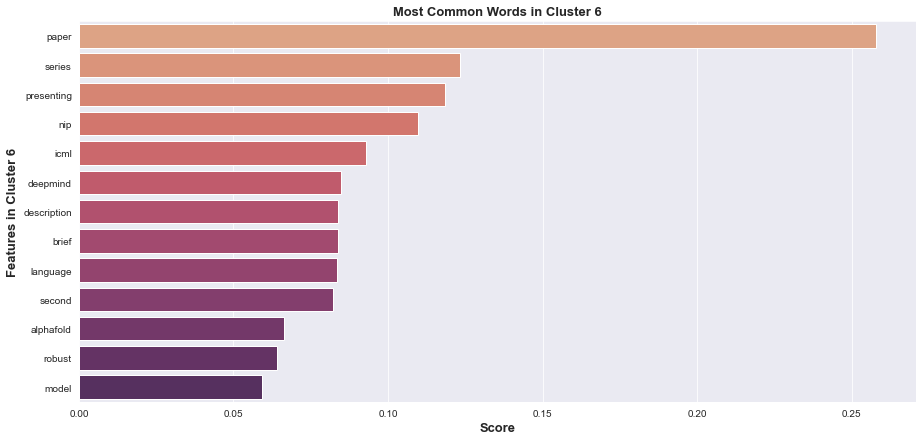

In [366]:
final_df_array = final_df.to_numpy()
prediction = kmeans.fit_predict(final_df)

n_feats = 20

dfs = get_top_features_cluster(final_df_array, prediction, n_feats, vec)

plotWords(dfs, 13)

## WordClouds

In [367]:
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure(figsize=(10, 6));
        plt.title((f'Most Common Words in Cluster {i}'), fontsize=20, fontweight='bold');
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        print('\n')

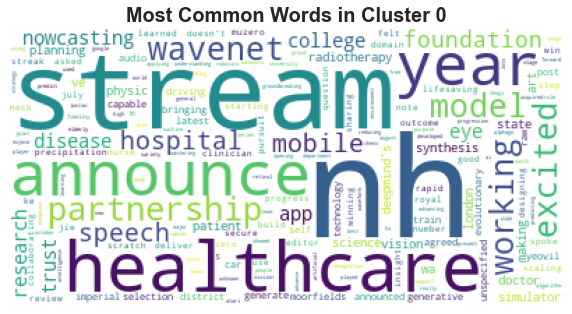

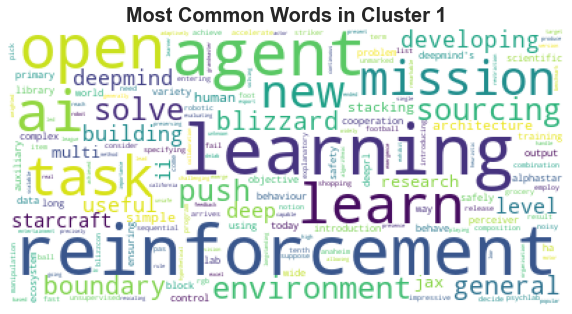

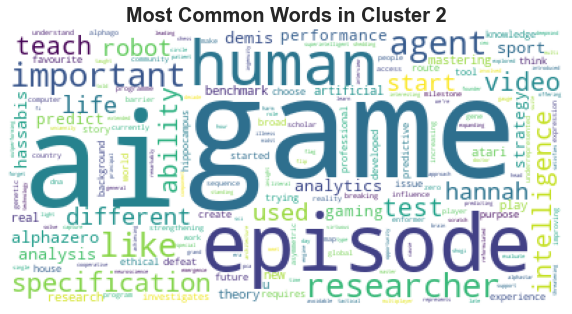

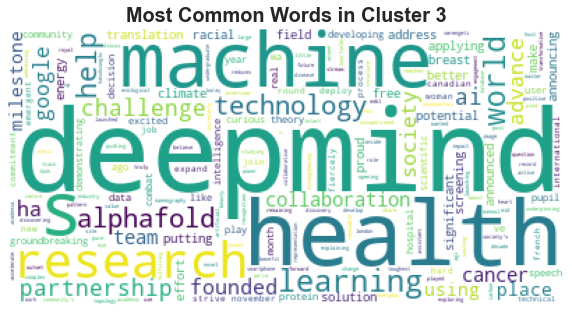

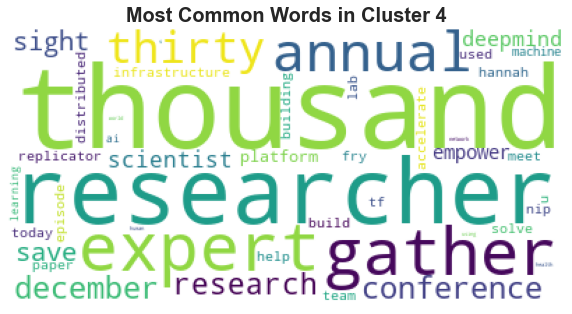

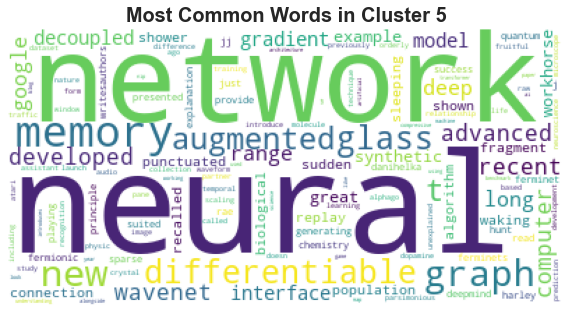

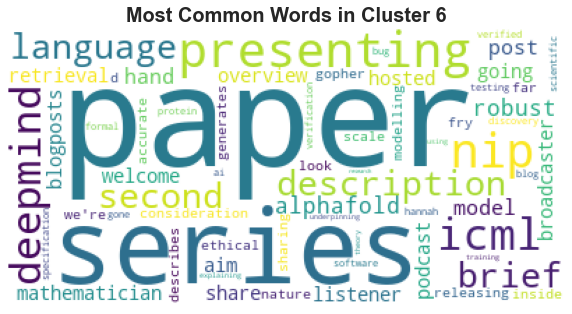

In [368]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

# Outputting excel file

Once you're satisfied with the clusters etc. you can go ahead and output the same excel file with the clusters column included so you know approximately what cluster the article would fall into (i.e. clusters 0-6)

In [370]:
df

,Title,Summary,Date,Type of Article,Day,Month,Year,Corpus
0,Language modelling at scale,"We are releasing three papers on language models, Gopher, ethical considerations, and retrieval",2021-12-08,Research,8,December,2021,"Language modelling at scale We are releasing three papers on language models, Gopher, ethical considerations, and retrieval"
1,Exploring the beauty of pure mathematics in novel ways,Discovering new patterns in the fields of topology and representation theory with machine learning,2021-12-01,Research,1,December,2021,Exploring the beauty of pure mathematics in novel ways Discovering new patterns in the fields of topology and representation theory with machine learning
2,Real-World Challenges for AGI,"Koray Kavukcuoglu, VP of Research, discusses why addressing real-world challenges now helps advance the development of",2021-11-02,Unspecified,2,November,2021,"Real-World Challenges for AGI Koray Kavukcuoglu, VP of Research, discusses why addressing real-world challenges now helps advance the development of"
3,Opening up a physics simulator for robotics,"As part of DeepMind's mission of advancing science, we have acquired the MuJoCo physics simulator and are making it",2021-10-18,News,18,October,2021,"Opening up a physics simulator for robotics As part of DeepMind's mission of advancing science, we have acquired the MuJoCo physics simulator and are making it"
4,Stacking our way to more general robots,Introducing RGB-Stacking as a new benchmark for vision-based robotic manipulation,2021-10-11,Research,11,October,2021,Stacking our way to more general robots Introducing RGB-Stacking as a new benchmark for vision-based robotic manipulation
...,...,...,...,...,...,...,...,...
100,Decoupled Neural Interfaces Using Synthetic Gradients,"Neural networks are the workhorse of many of the algorithms developed at DeepMind. For example, AlphaGo uses",2016-08-29,Research,29,August,2016,"Decoupled Neural Interfaces Using Synthetic Gradients Neural networks are the workhorse of many of the algorithms developed at DeepMind. For example, AlphaGo uses"
101,DeepMind AI Reduces Google Data Centre Cooling Bill by 40%,"From smartphone assistants to image recognition and translation, machine learning already helps us in our everyday",2016-07-20,Research,20,July,2016,"DeepMind AI Reduces Google Data Centre Cooling Bill by 40% From smartphone assistants to image recognition and translation, machine learning already helps us in our everyday"
102,Announcing DeepMind Health research partnership with Moorfields Eye Hospital,We founded DeepMind to make the world a better place by developing technologies that help address some of society's,2016-07-05,News,5,July,2016,Announcing DeepMind Health research partnership with Moorfields Eye Hospital We founded DeepMind to make the world a better place by developing technologies that help address some of society's
103,Deep Reinforcement Learning,"Humans excel at solving a wide variety of challenging problems, from low-level motor control through to high-level",2016-06-17,Research,17,June,2016,"Deep Reinforcement Learning Humans excel at solving a wide variety of challenging problems, from low-level motor control through to high-level"


In [377]:
def output_file(df, model):
    # Make a copy to avoid any unnecessary tampering
    df2 = df.copy()
    
    # Drop corpus column, no longer needed
    df2 = df2.drop('Corpus', axis=1)
    
    #Drop the 'Day', 'Month', and 'Year columns as they aren't needed
    df2 = df2.drop(['Day', 'Month', 'Year'], axis=1)

    #Make a new column 'labels' and assign the appropriate cluster labels to each article
    df2['Cluster'] = model.labels_
    
    return df2

In [378]:
df_end = output_file(df, kmeans)

In [379]:
filename_out = 'Deepmind_Scrape_TopicsClustered.xlsx' #Edit the name here if needed

df_end.to_excel(filename_out)